In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import csv

# Generar los datos XY

In [7]:
# Define the polynomial function
def polynomial(x):
    return 3 * x**3 + 2 * x**2 + 4 * x + 1


# Define a function to generate coordinates with random noise
def generate_data(n=100, noise_std=500):
    x = np.linspace(-15, 15, n)
    y = polynomial(x) + np.random.normal(-noise_std, noise_std, size=len(x))
    y = y / 100
    return x, y


# Define a function to save data to a CSV file
def save_to_csv(x, y, filename):
    data = {"X": x, "Y": y}
    df = pd.DataFrame(data)
    df.to_csv("polynomial_data.csv", index=False)


# Generate data
x, y = generate_data()
# Save the data to a CSV file
save_to_csv(x, y, "polynomial_data.csv")

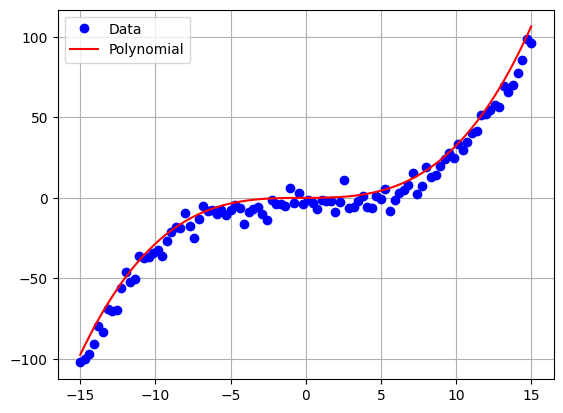

In [8]:
# Plot the data
plt.plot(x, y, "bo", label="Data")
plt.plot(x, polynomial(x) / 100, "r-", label="Polynomial")
plt.legend()
plt.grid()
plt.show()

In [9]:
data = pd.read_csv("polynomial_data.csv")
# data = pd.read_csv("datosXY.csv")
x, y = data["X"], data["Y"]

In [10]:
class GeneticAlgorithm:
    def __init__(
        self,
        num_generations: int,
        population_size: int,
        tournament_size: int,
        mutation_rate: float,
        num_coefficients: int,
    ):
        self.num_generations = num_generations
        self.population_size = population_size
        self.tournament_size = tournament_size
        self.mutation_rate = mutation_rate
        self.num_coefficients = num_coefficients

    def load_data(self, file_path):
        data = pd.read_csv(file_path)
        return data["X"].values, data["Y"].values

    def calculate_rmse(self, model, x, y):
        y_pred = model(x)
        rmse = np.sqrt(np.mean((y - y_pred) ** 2))
        return rmse

    def fitness(self, model, x, y):
        rmse = self.calculate_rmse(model, x, y)
        return 1 / (1 + rmse)

    def select_parents(self, population, fitness_values):
        selected_parents = []
        for _ in range(len(population)):
            tournament_indices = np.random.choice(
                len(population), self.tournament_size, replace=False
            )
            tournament_fitness = [fitness_values[i] for i in tournament_indices]
            winner_index = tournament_indices[np.argmax(tournament_fitness)]
            selected_parents.append(population[winner_index])
        return selected_parents

    def crossover(self, parent1, parent2):
        crossover_point = np.random.randint(1, len(parent1) - 1)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return child1, child2

    def mutate(self, individual):
        mutated_genes = np.random.rand(len(individual)) < self.mutation_rate
        individual[mutated_genes] += np.random.uniform(-0.1, 0.1, np.sum(mutated_genes))
        return individual

    def generate_individual(self):
        return np.random.rand(self.num_coefficients)

    def generate_model(self, coefficients):
        return lambda x: np.polyval(coefficients[::-1], x)

    def genetic_algorithm(self, data):
        x, y = data

        # Inicialización de la población con coeficientes aleatorios
        population = [self.generate_individual() for _ in range(self.population_size)]

        for generation in range(self.num_generations):
            # Evaluación del fitness de cada individuo en la población
            fitness_values = [
                self.fitness(self.generate_model(ind), x, y) for ind in population
            ]

            # Selección de padres
            parents = self.select_parents(population, fitness_values)

            # Creación de la nueva generación mediante cruce y mutación
            new_generation = []
            for i in range(0, self.population_size, 2):
                parent1, parent2 = parents[i], parents[i + 1]
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                new_generation.extend([child1, child2])

            # Reemplazo de la antigua generación por la nueva
            population = new_generation

        # Seleccionar el mejor individuo de la última generación
        fitness_values = [
            self.fitness(self.generate_model(ind), x, y) for ind in population
        ]
        best_individual_index = np.argmax(fitness_values)
        best_individual = population[best_individual_index]

        # Calcular el modelo asociado al mejor individuo
        best_model = self.generate_model(best_individual)

        # Calcular el RMSE asociado al mejor modelo
        best_rmse = self.calculate_rmse(best_model, x, y)

        return best_individual, best_rmse

    def plot_data_and_model(self, data, model_params):
        x, y = data
        model = self.generate_model(model_params)

        plt.scatter(x, y, label="Datos reales")
        x_range = np.linspace(min(x), max(x), 100)
        plt.plot(x_range, model(x_range), color="red", label="Modelo ajustado")
        plt.legend()
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Ajuste de curvas con Algoritmos Genéticos")
        plt.grid()
        plt.show()

Mejores coeficientes: [-1.96768262 -0.03386684 -0.00785935  0.03023072]
Error cuadrático medio asociado al ajuste: 4.5562081859767485


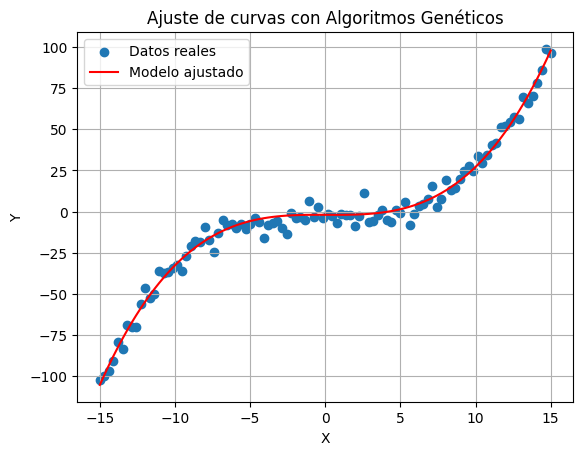

In [11]:
# Parámetros del algoritmo genético
num_generations = 100
population_size = 50
tournament_size = 5
mutation_rate = 0.3
# Ajusta el número de coeficientes según el grado polinomial deseado
num_coefficients = 4

# Instanciar el objeto GeneticAlgorithm
genetic_algo = GeneticAlgorithm(
    num_generations, population_size, tournament_size, mutation_rate, num_coefficients
)

# Cargar datos desde un archivo CSV
file_path = "polynomial_data.csv"
data = genetic_algo.load_data(file_path)

# Ejecutar el algoritmo genético
best_model_params, best_rmse = genetic_algo.genetic_algorithm(data)

# Mostrar resultados
print("Mejores coeficientes:", best_model_params)
print("Error cuadrático medio asociado al ajuste:", best_rmse)

# Graficar los resultados
genetic_algo.plot_data_and_model(data, best_model_params)